In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/lad1chka/HSE/DL/HSE_DL4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
cifar_dataset = load_dataset("cifar10")
print(f"Dataset loaded: {cifar_dataset}")
print(f"Train size: {len(cifar_dataset['train'])}, Test size: {len(cifar_dataset['test'])}")

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})
Train size: 50000, Test size: 10000


In [3]:
class SimpleImageDataset(Dataset):
    def __init__(self, hf_dataset, split='train'):
        self.data = []
        self.labels = []
        
        for item in hf_dataset[split]:
            img = np.array(item['img'])
            if len(img.shape) == 2:
                img = np.stack([img, img, img], axis=-1)
            self.data.append(torch.FloatTensor(img).permute(2, 0, 1) / 255.0)
            self.labels.append(item['label'])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = SimpleImageDataset(cifar_dataset, 'train')
test_dataset = SimpleImageDataset(cifar_dataset, 'test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Created dataloaders: train batches={len(train_loader)}, test batches={len(test_loader)}")

Created dataloaders: train batches=1563, test batches=313


In [4]:
class VSSDBlock(nn.Module):
    def __init__(self, dim, state_dim=16, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.state_dim = state_dim
        
        self.norm = nn.LayerNorm(dim)
        self.proj = nn.Linear(dim, 2 * dim)
        
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(dim, state_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(state_dim, dim) * 0.01)
        self.D = nn.Parameter(torch.randn(dim) * 0.01)
        
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        batch_size, seq_len, dim = x.shape
        
        x_norm = self.norm(x)
        u, v = self.proj(x_norm).chunk(2, dim=-1)
        
        h = torch.zeros(batch_size, self.state_dim, device=x.device)
        outputs = []
        
        for t in range(seq_len):
            h = torch.matmul(h, self.A) + torch.matmul(u[:, t], self.B)
            y_t = torch.matmul(h, self.C) + self.D * v[:, t]
            outputs.append(y_t.unsqueeze(1))
        
        y = torch.cat(outputs, dim=1)
        y = self.dropout(y)
        
        return x + y + self.mlp(x_norm)

class VSSD(nn.Module):
    def __init__(self, num_classes=10, img_size=32, patch_size=4, dim=128, depth=4):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.patch_embed = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, dim) * 0.02)
        
        self.blocks = nn.ModuleList([
            VSSDBlock(dim) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x.mean(dim=1))
        return self.head(x)

vssd_model = VSSD(num_classes=10, dim=96, depth=2).to(device)
print(f"VSSD model created: {sum(p.numel() for p in vssd_model.parameters())/1e6:.2f}M parameters")

VSSD model created: 0.20M parameters


In [5]:
class SimpleVSSD(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

cnn_model = SimpleCNN().to(device)
print(f"CNN baseline created: {sum(p.numel() for p in cnn_model.parameters())/1e6:.2f}M parameters")

CNN baseline created: 0.62M parameters


In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    
    return total_loss/len(loader), 100.*correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return total_loss/len(loader), 100.*correct/total

In [8]:
vssd_optimizer = optim.AdamW(vssd_model.parameters(), lr=1e-3, weight_decay=1e-4)
vssd_criterion = nn.CrossEntropyLoss()
vssd_scheduler = optim.lr_scheduler.CosineAnnealingLR(vssd_optimizer, T_max=5)

vssd_train_loss, vssd_train_acc = [], []
vssd_val_loss, vssd_val_acc = [], []

start_time = time.time()
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(vssd_model, train_loader, vssd_criterion, vssd_optimizer, device)
    val_loss, val_acc = evaluate(vssd_model, test_loader, vssd_criterion, device)
    
    vssd_train_loss.append(train_loss)
    vssd_train_acc.append(train_acc)
    vssd_val_loss.append(val_loss)
    vssd_val_acc.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    vssd_scheduler.step()

vssd_time = time.time() - start_time
print(f"\nVSSD training completed in {vssd_time:.1f} seconds")


Epoch 1/5
  Batch 0/1563, Loss: 2.4125
  Batch 100/1563, Loss: 2.1423
  Batch 200/1563, Loss: 1.7800
  Batch 300/1563, Loss: 1.8707
  Batch 400/1563, Loss: 1.7682
  Batch 500/1563, Loss: 1.5632
  Batch 600/1563, Loss: 1.6375
  Batch 700/1563, Loss: 1.4722
  Batch 800/1563, Loss: 1.4424
  Batch 900/1563, Loss: 1.6383
  Batch 1000/1563, Loss: 1.8555
  Batch 1100/1563, Loss: 1.7175
  Batch 1200/1563, Loss: 1.3764
  Batch 1300/1563, Loss: 1.2411
  Batch 1400/1563, Loss: 1.8450
  Batch 1500/1563, Loss: 1.4876
Train Loss: 1.7138, Train Acc: 35.91%
Val Loss: 1.4142, Val Acc: 48.52%

Epoch 2/5
  Batch 0/1563, Loss: 1.5054
  Batch 100/1563, Loss: 1.3397
  Batch 200/1563, Loss: 1.7427
  Batch 300/1563, Loss: 1.4622
  Batch 400/1563, Loss: 1.2196
  Batch 500/1563, Loss: 1.3006
  Batch 600/1563, Loss: 1.5925
  Batch 700/1563, Loss: 1.3362
  Batch 800/1563, Loss: 1.4273
  Batch 900/1563, Loss: 1.6029
  Batch 1000/1563, Loss: 1.1184
  Batch 1100/1563, Loss: 1.5171
  Batch 1200/1563, Loss: 1.4137
  

In [9]:
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_criterion = nn.CrossEntropyLoss()

cnn_train_loss, cnn_train_acc = [], []
cnn_val_loss, cnn_val_acc = [], []

start_time = time.time()
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(cnn_model, train_loader, cnn_criterion, cnn_optimizer, device)
    val_loss, val_acc = evaluate(cnn_model, test_loader, cnn_criterion, device)
    
    cnn_train_loss.append(train_loss)
    cnn_train_acc.append(train_acc)
    cnn_val_loss.append(val_loss)
    cnn_val_acc.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

cnn_time = time.time() - start_time
print(f"\nCNN training completed in {cnn_time:.1f} seconds")


Epoch 1/5
  Batch 0/1563, Loss: 2.3030
  Batch 100/1563, Loss: 2.0175
  Batch 200/1563, Loss: 2.1548
  Batch 300/1563, Loss: 1.7156
  Batch 400/1563, Loss: 1.6652
  Batch 500/1563, Loss: 1.5458
  Batch 600/1563, Loss: 1.4947
  Batch 700/1563, Loss: 1.3351
  Batch 800/1563, Loss: 1.5574
  Batch 900/1563, Loss: 1.6538
  Batch 1000/1563, Loss: 1.4888
  Batch 1100/1563, Loss: 1.5562
  Batch 1200/1563, Loss: 1.7191
  Batch 1300/1563, Loss: 1.5606
  Batch 1400/1563, Loss: 1.3369
  Batch 1500/1563, Loss: 1.2555
Train Loss: 1.6357, Train Acc: 39.80%
Val Loss: 1.2604, Val Acc: 54.80%

Epoch 2/5
  Batch 0/1563, Loss: 1.0973
  Batch 100/1563, Loss: 1.4764
  Batch 200/1563, Loss: 1.1135
  Batch 300/1563, Loss: 1.3784
  Batch 400/1563, Loss: 1.4153
  Batch 500/1563, Loss: 1.0879
  Batch 600/1563, Loss: 1.2969
  Batch 700/1563, Loss: 1.1385
  Batch 800/1563, Loss: 1.5965
  Batch 900/1563, Loss: 1.4513
  Batch 1000/1563, Loss: 1.0423
  Batch 1100/1563, Loss: 1.1249
  Batch 1200/1563, Loss: 1.3105
  

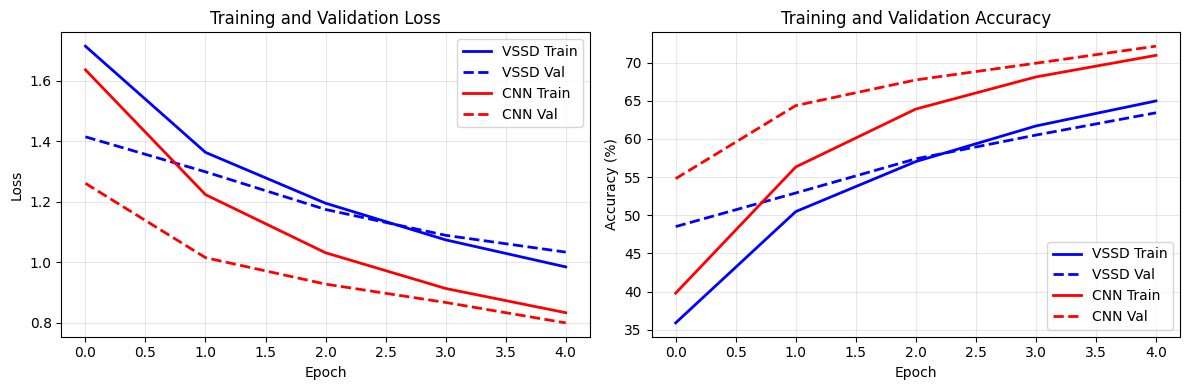

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vssd_train_loss, 'b-', label='VSSD Train', linewidth=2)
plt.plot(vssd_val_loss, 'b--', label='VSSD Val', linewidth=2)
plt.plot(cnn_train_loss, 'r-', label='CNN Train', linewidth=2)
plt.plot(cnn_val_loss, 'r--', label='CNN Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(vssd_train_acc, 'b-', label='VSSD Train', linewidth=2)
plt.plot(vssd_val_acc, 'b--', label='VSSD Val', linewidth=2)
plt.plot(cnn_train_acc, 'r-', label='CNN Train', linewidth=2)
plt.plot(cnn_val_acc, 'r--', label='CNN Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

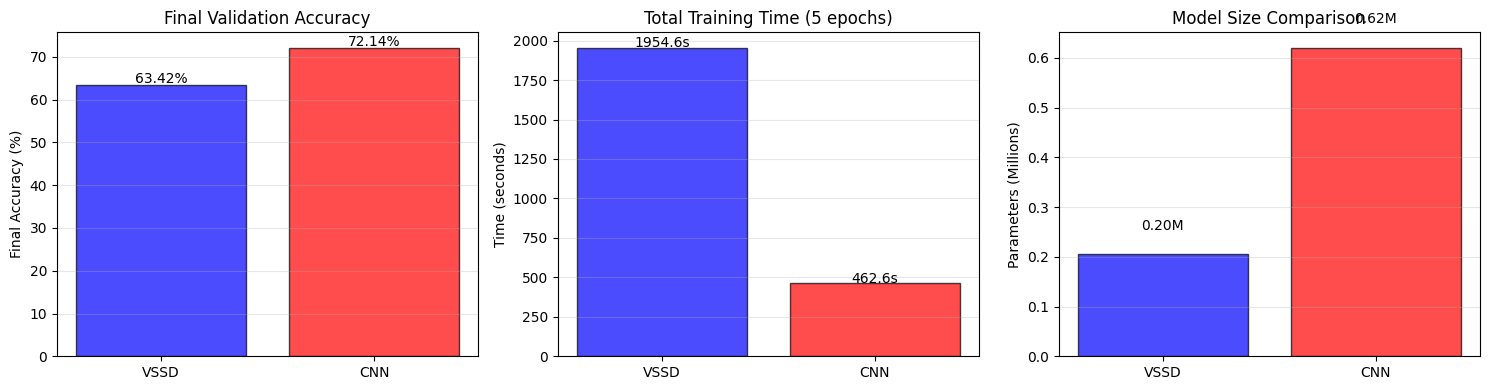

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

final_accuracies = [vssd_val_acc[-1], cnn_val_acc[-1]]
models = ['VSSD', 'CNN']
colors = ['blue', 'red']

axes[0].bar(models, final_accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Final Accuracy (%)')
axes[0].set_title('Final Validation Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(final_accuracies):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center')

training_times = [vssd_time, cnn_time]
axes[1].bar(models, training_times, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Total Training Time (5 epochs)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(training_times):
    axes[1].text(i, v + 2, f'{v:.1f}s', ha='center')

param_counts = [
    sum(p.numel() for p in vssd_model.parameters())/1e6,
    sum(p.numel() for p in cnn_model.parameters())/1e6
]
axes[2].bar(models, param_counts, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Parameters (Millions)')
axes[2].set_title('Model Size Comparison')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(param_counts):
    axes[2].text(i, v + 0.05, f'{v:.2f}M', ha='center')

plt.tight_layout()
plt.show()

In [12]:
vssd_model.eval()
cnn_model.eval()

test_samples = 5
correct_vssd, correct_cnn = 0, 0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if i >= test_samples:
            break
        
        data, target = data.to(device), target.to(device)
        
        vssd_output = vssd_model(data)
        cnn_output = cnn_model(data)
        
        _, vssd_pred = vssd_output.max(1)
        _, cnn_pred = cnn_output.max(1)
        
        correct_vssd += (vssd_pred == target).sum().item()
        correct_cnn += (cnn_pred == target).sum().item()
        
        print(f"Sample {i+1}:")
        print(f"  True: {class_names[target[0].item()]}")
        print(f"  VSSD Prediction: {class_names[vssd_pred[0].item()]}")
        print(f"  CNN Prediction: {class_names[cnn_pred[0].item()]}")

print(f"\nSample accuracy (32*{test_samples} images):")
print(f"  VSSD: {100.*correct_vssd/(32*test_samples):.1f}%")
print(f"  CNN: {100.*correct_cnn/(32*test_samples):.1f}%")

Sample 1:
  True: cat
  VSSD Prediction: cat
  CNN Prediction: dog
Sample 2:
  True: deer
  VSSD Prediction: deer
  CNN Prediction: deer
Sample 3:
  True: frog
  VSSD Prediction: frog
  CNN Prediction: frog
Sample 4:
  True: frog
  VSSD Prediction: frog
  CNN Prediction: deer
Sample 5:
  True: dog
  VSSD Prediction: cat
  CNN Prediction: cat

Sample accuracy (32*5 images):
  VSSD: 68.8%
  CNN: 75.0%


На абсолютно всех эпохах CNN показала результат лучше по всем метрикам, также обучение было в 3 раза быстрее. Это можно связать со следующими причинами:
- Избыточная сложность VSSD для маленьких изображений
- State-space модель требует точной настройки гиперпараметров
- Архитектура может быть не настроена для CIFAR-10
Хоть и на тестовых примерах она показала себя лучше в 2 раза